<a href="https://colab.research.google.com/github/graviada/DataScienceProjects/blob/main/Huawei%20(2022)/Credit_German.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Домашнее задание**
### **Задача**:

macro_avg = 0.75 и выше

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')     # Стиль графиков, можно закомментировать
plt.rcParams['figure.figsize'] = (10, 7.5)              

import torch
import scipy.stats as ss
import statsmodels.api as sm
from seaborn import heatmap
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

import sklearn
import sklearn.datasets as datasets
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, classification_report, confusion_matrix

### **Изучение датасета**

In [58]:
data_home = datasets.fetch_openml(name='credit-g')       # Загрузка датасета с OpenML

In [59]:
Predictors_home = data_home.get('data')
Target_home = data_home.get('target')

**Описание атрибутов датасета**

        - checking_status         Состояние существующего расчетного счета в немецких марках
        - duration                Промежуток, на который брался счет в месяцах
        - credit_history          Кредитная история (взятые кредиты, своевременно погашенные, просрочки, критические счета)
        - purpose                 Цель кредита (автомобиль, телевизор, др.)
        - credit_amount           Сумма кредита
        - savings_status          Состояние сберегательного счета/облигаций в немецких марках
        - employment              Текущая занятость, количество лет в виде промежутка
        - installment_commitment  Ставка рассрочки в процентах от располагаемого дохода
        - personal_status         Личный статус (замужем, холост, др.) и пол
        - other_parties           Прочие должники/поручители
        - residence_since         Настоящее место жительства с X лет (в годах)
        - property_magnitude      Имущество (например, недвижимость)
        - age                     Возраст в годах
        - other_payment_plans     Другие виды рассрочки (банки, магазины)
        - housing                 Жилье (аренда, собственное, др.)
        - existing_credits        Количество существующих кредитов в этом банке
        - job                     Работа
        - num_dependents          Количество лиц, на которых возложена обязанность по содержанию
        - own_telephone           Телефон (да, нет)
        - foreign_worker          Иностранный работник (да, нет)

In [60]:
Predictors_home.describe()

,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000


In [61]:
Predictors_home.employment.cat.categories

Index(['unemployed', '<1', '1<=X<4', '4<=X<7', '>=7'], dtype='object')

In [62]:
Predictors_home.personal_status.cat.categories

Index(['male div/sep', 'female div/dep/mar', 'male single', 'male mar/wid',
       'female single'],
      dtype='object')

In [63]:
Predictors_home.other_parties.cat.categories

Index(['none', 'co applicant', 'guarantor'], dtype='object')

In [64]:
Predictors_home.residence_since.infer_objects

<bound method NDFrame.infer_objects of 0      4.0
1      2.0
2      3.0
3      4.0
4      4.0
      ... 
995    4.0
996    4.0
997    4.0
998    4.0
999    4.0
Name: residence_since, Length: 1000, dtype: float64>

С помощью функции info() посмотрим краткое описание данных. Нас будут интересовать размер датасета, тип данных, наличие нулевых (NaN) значений.

In [65]:
Predictors_home.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   checking_status         1000 non-null   category
 1   duration                1000 non-null   float64 
 2   credit_history          1000 non-null   category
 3   purpose                 1000 non-null   category
 4   credit_amount           1000 non-null   float64 
 5   savings_status          1000 non-null   category
 6   employment              1000 non-null   category
 7   installment_commitment  1000 non-null   float64 
 8   personal_status         1000 non-null   category
 9   other_parties           1000 non-null   category
 10  residence_since         1000 non-null   float64 
 11  property_magnitude      1000 non-null   category
 12  age                     1000 non-null   float64 
 13  other_payment_plans     1000 non-null   category
 14  housing                 1

In [66]:
Target_home.infer_objects

<bound method NDFrame.infer_objects of 0      good
1       bad
2      good
3      good
4       bad
       ... 
995    good
996    good
997    good
998     bad
999    good
Name: class, Length: 1000, dtype: category
Categories (2, object): ['good', 'bad']>

In [67]:
sum(Target_home.isna())

0

In [68]:
# Составим словарь, в котором ключами будут являться типы данных в датафрейме, а значениями - названия колонок
category_dict = Predictors_home.columns.groupby(Predictors_home.dtypes)
category_dict

{category: ['checking_status'], float64: ['duration', 'credit_amount', 'installment_commitment', 'residence_since', 'age', 'existing_credits', 'num_dependents'], category: ['credit_history'], category: ['purpose'], category: ['savings_status'], category: ['employment'], category: ['personal_status'], category: ['other_parties'], category: ['property_magnitude'], category: ['other_payment_plans'], category: ['housing'], category: ['job'], category: ['own_telephone'], category: ['foreign_worker']}

In [69]:
categories = ['checking_status', 'credit_history', 'purpose',
                                'savings_status', 'employment', 'personal_status',
                                'other_parties', 'property_magnitude', 'other_payment_plans',
                                'housing', 'job', 'own_telephone', 'foreign_worker']

**Итог:**

Размер набора примеров: 1000

Количество признаков: 21

Количество пропущенных значений: 0

Категориальных типов: 13

In [70]:
concat_home = pd.concat([Predictors_home, Target_home], axis=1)
concat_home.groupby('class').mean()

,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents
class,,,,,,,
good,19.207143,2985.457143,2.920000,2.842857,36.224286,1.424286,1.155714
bad,24.860000,3938.126667,3.096667,2.850000,33.963333,1.366667,1.153333


**Наблюдения:**

1. Дебиторы младше в среднем берут кредит на большую сумму и на больший срок и склонны не возвращать кредит.
2. Более долгосрочный кредит имеет больше шансов быть невыплаченным.

Посмотрим на влияние других категориальных переменных:

Text(0, 0.5, 'Частота')

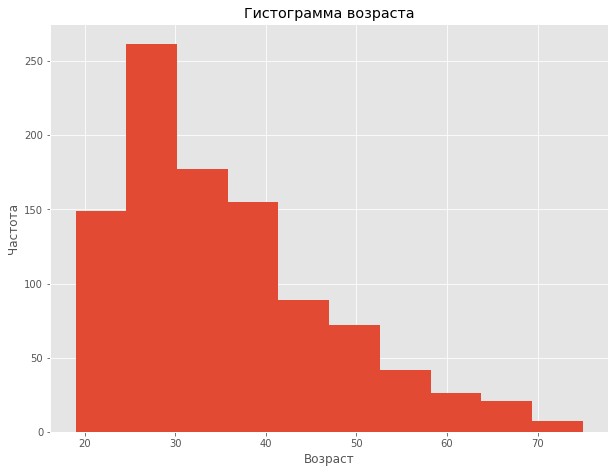

In [71]:
concat_home.age.hist()
plt.title('Гистограмма возраста')
plt.xlabel('Возраст')
plt.ylabel('Частота')

Большинство клиентов банка находится в возрасте от 25 до 35.

In [72]:
concat_home.loc[(concat_home.age > 24) & (concat_home.age < 36)].groupby('class').mean()

,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents
class,,,,,,,
good,20.192053,3091.311258,2.920530,2.403974,29.817881,1.387417,1.125828
bad,24.058394,3715.956204,3.094891,2.576642,29.321168,1.401460,1.087591


In [73]:
concat_home.groupby('job').mean()

,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents
job,,,,,,,
unemp/unskilled non res,17.363636,2745.136364,2.318182,2.590909,40.090909,1.636364,1.136364
unskilled resident,16.535000,2358.520000,2.845000,2.865000,36.540000,1.395000,1.260000
skilled,21.411111,3070.965079,3.009524,2.844444,34.253968,1.406349,1.125397
high qualif/self emp/mgmt,25.168919,5435.493243,3.087838,2.858108,39.027027,1.391892,1.141892


Как видим, наибольшая сумма кредита в среднем относится к людям на высокой должности. Время заема для них так же является наибольшим.

Клиенты без квалификации берут наименьшие по сумме и по продолжительности кредиты.

In [74]:
concat_home.groupby('employment').mean()

,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents
employment,,,,,,,
unemployed,20.661290,4216.758065,2.758065,3.000000,40.435484,1.435484,1.096774
<1,19.401163,2952.453488,2.889535,2.447674,30.308140,1.284884,1.116279
1<=X<4,20.365782,3125.286136,2.864307,2.628319,33.085546,1.348083,1.138643
4<=X<7,22.994253,3601.695402,2.971264,2.770115,33.477011,1.454023,1.172414
>=7,21.264822,3224.624506,3.229249,3.418972,42.628458,1.529644,1.205534


Однако при этом безработные склонны в целом брать кредит на наибольшие суммы. Вероятно, в выборке есть высоко квалифицированные работники, не работающие на данный момент.

In [75]:
concat_home.groupby('foreign_worker').mean()

,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents
foreign_worker,,,,,,,
yes,21.229491,3298.936656,2.992731,2.856698,35.559709,1.408100,1.149533
no,12.405405,2550.864865,2.459459,2.540541,35.189189,1.378378,1.297297


При этом иностранцы берут кредит на большие суммы и большие сроки.

In [76]:
concat_home.groupby('personal_status').mean()

,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents
personal_status,,,,,,,
male div/sep,21.240000,3684.700000,2.500000,2.660000,38.640000,1.340000,1.060000
female div/dep/mar,19.438710,2877.774194,2.829032,2.867742,32.803226,1.325806,1.045161
male single,22.237226,3661.903285,3.093066,2.908759,37.687956,1.468978,1.248175
male mar/wid,17.706522,2045.543478,3.000000,2.489130,30.347826,1.347826,1.021739
female single,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [77]:
concat_home.loc[concat_home.personal_status=='female single']

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class


Нам попалась совершенно неинформативная категория 'женщина, не замужем'. В датасете такие примеры отсутствуют, а, следовательно, это никак не повлияет на наше обучение.

Мужчины склонны в среднем брать кредит на большие суммы, чем женщины. При этом в основном это будут разведенные или одинокие клиенты.

### **Подготовка данных**

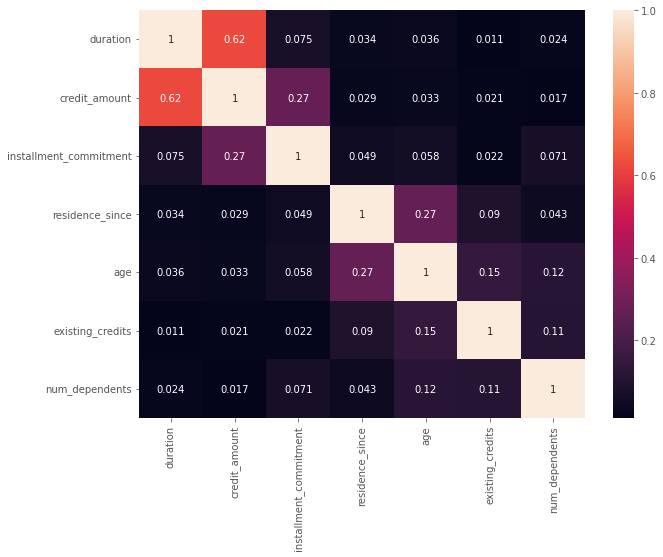

In [78]:
# Корреляция всех представленных атрибутов друг с другом (только числовые)
heatmap(abs(Predictors_home.corr()), annot=True)

Интерес представляет лишь взаимная корреляция duration и credit_amount (0.62). Очевидно, что большие суммы действительно будут превалировать в долгосрочных перспективах - это может быть ипотека, покупка автомобиля кредит - все то, на что у клиента нет возможности платить крупными суммами.

Теперь рассмотрим корреляцию категориальных переменных с помощью V-коэффициента Крамера.

In [79]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [80]:
cramerDict = {}

for i in categories:
  for j in categories:    
    if i != j:
      k= i + '_' + j
      cramerDict[k] = cramers_v(Predictors_home[i], Predictors_home[j])

# cramerDict

In [81]:
koefMoreHalf_cramerDict = {key: value for key, value in cramerDict.items() if value > 0.5}
koefMoreHalf_cramerDict

{'housing_property_magnitude': 0.5510116404863402,
 'property_magnitude_housing': 0.5510116404863402}

Как видим, жилье и имущество являются наиболее зависимыми колонками. Пока так же ничего примечательного. 
Для окончательного вывода посмотрим общую корреляцию всех признаков.

In [82]:
measurements = ['duration', 'credit_amount', 'installment_commitment', 'residence_since', 'age', 'existing_credits', 'num_dependents']

In [83]:
def correlation_ratio(categories, measurements):
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0,cat_num):
        cat_measures = measurements[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
    denominator = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = np.sqrt(numerator/denominator)
    return eta

In [84]:
corrDict = {}

for i in categories:
  for j in measurements:
    k= i + '_' + j
    corrDict[k] = correlation_ratio(Predictors_home[i], Predictors_home[j])

# corrDict

In [85]:
koefMoreHalf_corrDict = {key: value for key, value in corrDict.items() if value > 0.5}
koefMoreHalf_corrDict

{'credit_history_existing_credits': 0.595093979617754}

Итого мы имеем следующие корреляционные зависимости, большие 0.5:

1. Корреляция между числовыми и категориальными признаками: **credit_history и existing_credits:** 0.595093979617754
2. Корреляция между категориальными и категориальными признаками: **housing и property_magnitude:** 0.5510116404863402
3. Корреляция между числовыми признаками и числовыми признаками: **duration и credit_amount:** 0.62

Пока что оставим эту информацию и попробуем воспользоваться этими данными позже.

Напоследок посмотрим общую корреляцию с таргетом.


In [86]:
targetCorrDict = {}

# Таргет и числовые
for i in measurements:
    k= 'target' + '_' + i
    targetCorrDict[k] = correlation_ratio(Target_home, Predictors_home[i])

# Таргет и категории
for i in categories:
    k= 'target' + '_' + i
    targetCorrDict[k] = cramers_v(Target_home, Predictors_home[i])

targetCorrDict

{'target_age': 0.09112740931949907,
 'target_checking_status': 0.3476189010590424,
 'target_credit_amount': 0.15473864110152377,
 'target_credit_history': 0.24030230119486998,
 'target_duration': 0.2149266654418908,
 'target_employment': 0.11991106245316734,
 'target_existing_credits': 0.04573248933920645,
 'target_foreign_worker': 0.06946513621535383,
 'target_housing': 0.12733448032933792,
 'target_installment_commitment': 0.07240393725133044,
 'target_job': 0.0,
 'target_num_dependents': 0.003014853083344684,
 'target_other_parties': 0.06817636837744626,
 'target_other_payment_plans': 0.10415394681626368,
 'target_own_telephone': 0.013104557655738317,
 'target_personal_status': 0.08129468862215453,
 'target_property_magnitude': 0.14400453584964393,
 'target_purpose': 0.1561148105809381,
 'target_residence_since': 0.0029671587541552726,
 'target_savings_status': 0.17924029522149437}

Каких-то явных зависимостей обнаружено не было.

Теперь создадим дамми-переменные из категориальных типов.

In [87]:
# Создание копии оригинального датафрейма
Predictors_dummies = Predictors_home.copy()
Predictors_dummies = pd.get_dummies(Predictors_dummies, categories)
Predictors_dummies.head(3)

,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents,checking_status_<0,checking_status_0<=X<200,checking_status_>=200,...,housing_own,housing_for free,job_unemp/unskilled non res,job_unskilled resident,job_skilled,job_high qualif/self emp/mgmt,own_telephone_none,own_telephone_yes,foreign_worker_yes,foreign_worker_no
0,6.0,1169.0,4.0,4.0,67.0,2.0,1.0,1,0,0,...,1,0,0,0,1,0,0,1,1,0
1,48.0,5951.0,2.0,2.0,22.0,1.0,1.0,0,1,0,...,1,0,0,0,1,0,1,0,1,0
2,12.0,2096.0,2.0,3.0,49.0,1.0,2.0,0,0,0,...,1,0,0,1,0,0,1,0,1,0


In [88]:
Predictors_dummies = Predictors_dummies[Predictors_dummies.columns].astype('float')

In [89]:
Predictors_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 63 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   duration                                       1000 non-null   float64
 1   credit_amount                                  1000 non-null   float64
 2   installment_commitment                         1000 non-null   float64
 3   residence_since                                1000 non-null   float64
 4   age                                            1000 non-null   float64
 5   existing_credits                               1000 non-null   float64
 6   num_dependents                                 1000 non-null   float64
 7   checking_status_<0                             1000 non-null   float64
 8   checking_status_0<=X<200                       1000 non-null   float64
 9   checking_status_>=200                          1000 n

In [90]:
list_null = [print(i) for i in range(61) if sum(Predictors_dummies.iloc[:, i]) == 0]
print(list_null)

23
41
[None, None]


In [91]:
Predictors_dummies = Predictors_dummies.drop(['personal_status_female single', 'purpose_vacation'], 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


In [92]:
Target_home

0      good
1       bad
2      good
3      good
4       bad
       ... 
995    good
996    good
997    good
998     bad
999    good
Name: class, Length: 1000, dtype: category
Categories (2, object): ['good', 'bad']

In [93]:
# Преобразуем таргет
Target_dict = {'good': 1, 'bad': 0}
unique_targets = list(set(Target_home))
Target_dummies = Target_home.replace(to_replace=unique_targets, value=list(Target_dict.values()))

{'good': 1, 'bad': 0}


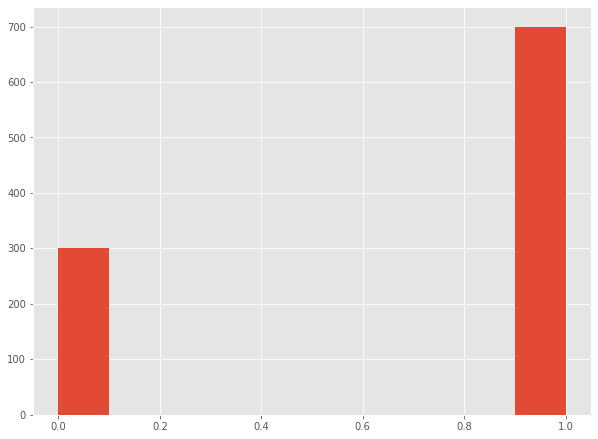

In [94]:
# Посмотрим на сбалансированность данных
plt.hist(Target_dummies)
print(Target_dict)

Плохих дебиторов больше, чем хороших. Балансировка составляет 700 плохих дебиторов к 300 хорошим. Попробуем изменить баланс.

In [95]:
biggerDF = pd.concat([Predictors_dummies, Target_dummies], axis=1)

In [96]:
rat = 700//300
bigger_df = biggerDF.loc[biggerDF['class']==0]
bigger_df = bigger_df.loc[bigger_df.index.repeat(rat)]
biggerDF_modified = pd.concat([biggerDF.loc[biggerDF['class']==1], bigger_df]).sample(frac=1)
biggerDF_modified.head(3)

,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents,checking_status_<0,checking_status_0<=X<200,checking_status_>=200,...,housing_for free,job_unemp/unskilled non res,job_unskilled resident,job_skilled,job_high qualif/self emp/mgmt,own_telephone_none,own_telephone_yes,foreign_worker_yes,foreign_worker_no,class
365,12.0,1542.0,2.0,4.0,36.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1
244,12.0,3447.0,4.0,3.0,35.0,1.0,2.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1
474,18.0,1245.0,4.0,2.0,33.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0


600 700


(array([600.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 700.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

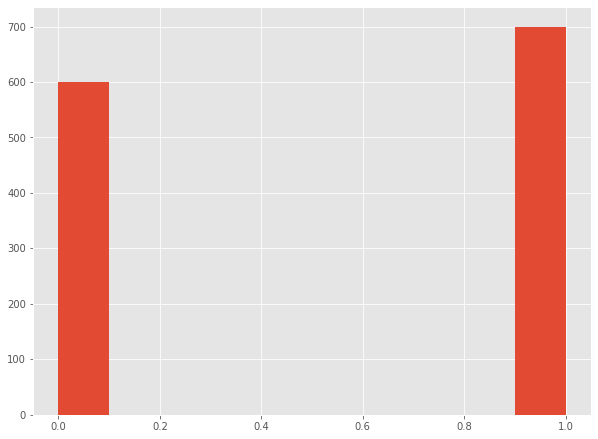

In [97]:
len_1 = len(biggerDF_modified.loc[biggerDF_modified['class']==0])
len_2 = len(biggerDF_modified.loc[biggerDF_modified['class']==1])
print(len_1, len_2)

# Посмотрим на сбалансированность данных
plt.hist(biggerDF_modified['class'])

Как видим, нам удалось немного сбалансировать данные. Теперь разделим выборки на обучающую и тестовую.

In [98]:
index_list = np.asarray([i for i in range(len(biggerDF_modified))])

Predictors_dummies = pd.DataFrame(biggerDF_modified.iloc[:, :-1].values, index=index_list)
Target_dummies = pd.Series(biggerDF_modified['class'].values, index=index_list)

Predictors_dummies.head(3)

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,12.0,1542.0,2.0,4.0,36.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
1,12.0,3447.0,4.0,3.0,35.0,1.0,2.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,18.0,1245.0,4.0,2.0,33.0,1.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


### **Обучение моделей**
### Логистическая регрессия
**Дополнительное условие к проверке качества работы модели:**

Хуже классифицировать клиента как хорошего, когда он плохой (5), чем классифицировать клиента как плохого, когда он хороший(1).

In [100]:
# Для выведения результатов
def results(model, X_test, Y_test, unique_targets):
  preds = model.predict(X_test)
  print(confusion_matrix(Y_test, preds))
  print(classification_report(Y_test, preds, target_names = unique_targets))

In [101]:
def good_features(model, n_features, predictors, target):

  rfe = RFE(model, n_features_to_select=n_features)
  rfe = rfe.fit(predictors, target.values.ravel())

  rank_log = pd.DataFrame(rfe.support_,index=predictors.columns,columns=['Rank'])
  needful_features = np.asarray(rank_log.loc[rank_log.Rank == np.bool_('True')].index)

  X = predictors[needful_features]
  y = target

  return X, y

In [436]:
test_ratio = 0.23

X_train, X_test, y_train, y_test = train_test_split(Predictors_dummies, 
                                                    Target_dummies, 
                                                    stratify=Target_dummies,
                                                    test_size = test_ratio, 
                                                    random_state=123)

print(X_train.shape)
print(X_test.shape)

print(f"Количество строк в y_train по классам: {np.bincount(y_train)}")
print(f"Количество строк в y_test по классам: {np.bincount(y_test)}")

(1001, 61)
(299, 61)
Количество строк в y_train по классам: [462 539]
Количество строк в y_test по классам: [138 161]


In [181]:
# X, y = good_features(model_LogisticReg, 28, Predictors_dummies, Target_dummies)

In [135]:
# Удаляем колонки
# needful_features = np.asarray([2,  5,  11, 12, 15, 16, 17, 19, 22, 23, 26,
#        29, 30, 34, 35, 38, 41, 42, 43, 46, 49, 50, 53, 57])

# X = Predictors_dummies[needful_features]

# logit_model = sm.Logit(y,X)
# result = logit_model.fit()
# print(result.summary2())

In [442]:
# X_train, X_test, y_train, y_test = train_test_split(X, 
#                                                     y, 
#                                                     test_size=0.25, 
#                                                     random_state=123)

model_LogisticReg = LogisticRegression(penalty='l2', C=0.08, random_state=0, solver='liblinear')
model_LogisticReg.fit(X_train, y_train)
model_LogisticReg.score(X_train, y_train)

0.7492507492507493

In [443]:
results(model_LogisticReg, X_test, y_test, unique_targets)

[[102  36]
 [ 35 126]]
              precision    recall  f1-score   support

        good       0.74      0.74      0.74       138
         bad       0.78      0.78      0.78       161

    accuracy                           0.76       299
   macro avg       0.76      0.76      0.76       299
weighted avg       0.76      0.76      0.76       299



**Итог:**

Полученная модель не является достаточно эффективной, так как она склонна классифицировать плохих дебиторов как хороших в соотношении 0.97 вместо 0.2.

In [284]:
# X, y = good_features(model_logistic_CV, 28, Predictors_dummies, Target_dummies)

In [500]:
# X_train, X_test, y_train, y_test = train_test_split(X, 
#                                                     y, 
#                                                     test_size = 0.2, 
#                                                     random_state=123)

model_logistic_CV = LogisticRegressionCV(penalty='l2', solver='newton-cg',
                                         cv=6)

model_logistic_CV.fit(X_train, y_train)
model_logistic_CV.score(X_train, y_train)

Rounding errors prevent the line search from converging
The line search algorithm did not converge
Line Search failed


0.7582417582417582

In [501]:
results(model_logistic_CV, X_test, y_test, unique_targets)

[[ 99  39]
 [ 36 125]]
              precision    recall  f1-score   support

        good       0.73      0.72      0.73       138
         bad       0.76      0.78      0.77       161

    accuracy                           0.75       299
   macro avg       0.75      0.75      0.75       299
weighted avg       0.75      0.75      0.75       299



In [502]:
36/39

0.9230769230769231

**Итог:**

Данная модель оказалась чуть более эффективной с точки зрения оценки на тесте и соотношения 0.92. Однако macro_avg=0.75

### KNN (Метод k ближайших соседей)

In [324]:
sklearn.neighbors.VALID_METRICS['ball_tree']

['euclidean',
 'l2',
 'minkowski',
 'p',
 'manhattan',
 'cityblock',
 'l1',
 'chebyshev',
 'infinity',
 'seuclidean',
 'mahalanobis',
 'wminkowski',
 'hamming',
 'canberra',
 'braycurtis',
 'matching',
 'jaccard',
 'dice',
 'kulsinski',
 'rogerstanimoto',
 'russellrao',
 'sokalmichener',
 'sokalsneath',
 'haversine',
 'pyfunc']

In [521]:
number_of_neighbors = np.arange(3, 20, 2)
model_KNN = KNeighborsClassifier(algorithm='ball_tree', metric='russellrao')
params = {
    "n_neighbors": number_of_neighbors
    }

grid_search = GridSearchCV(estimator = model_KNN, 
                           param_grid = params, 
                           cv = 6, 
                           scoring = "f1_macro")

In [522]:
grid_search.fit(X_train, y_train)
print(grid_search.best_score_, grid_search.best_estimator_)

0.6991056797679054 KNeighborsClassifier(algorithm='ball_tree', metric='russellrao')


In [523]:
preds_knn = grid_search.predict(X_test)

print(confusion_matrix(y_test, preds_knn))
print(classification_report(y_test, preds_knn))

[[106  32]
 [ 38 123]]
              precision    recall  f1-score   support

           0       0.74      0.77      0.75       138
           1       0.79      0.76      0.78       161

    accuracy                           0.77       299
   macro avg       0.76      0.77      0.77       299
weighted avg       0.77      0.77      0.77       299



**Итог:**

Данная модель хуже предыдущих по критерию ошибочного распознавания (1.18), ее точность составляет всего 0.699.

### SVM (Машина опорных векторов)

Не работает!

In [378]:
# line_param = np.linspace(1, 10, 20)
# parameters = {'kernel':['linear'], 'C':line_param}
# model = SVC()
# grid_search_svm = GridSearchCV(estimator=model, param_grid=parameters, cv = 6)
# grid_search_svm.fit(X_train, y_train)
# grid_search_svm.best_score_

# grid_search_svm.best_estimator_

# preds_svm = grid_search_svm.predict(X_test).to(device)

# print(confusion_matrix(y_test, preds_svm))
# print(classification_report(y_test, preds_svm, target_names = unique_targets))

### Заключение

Лучшей моделью оказалась model_logistic_CV.